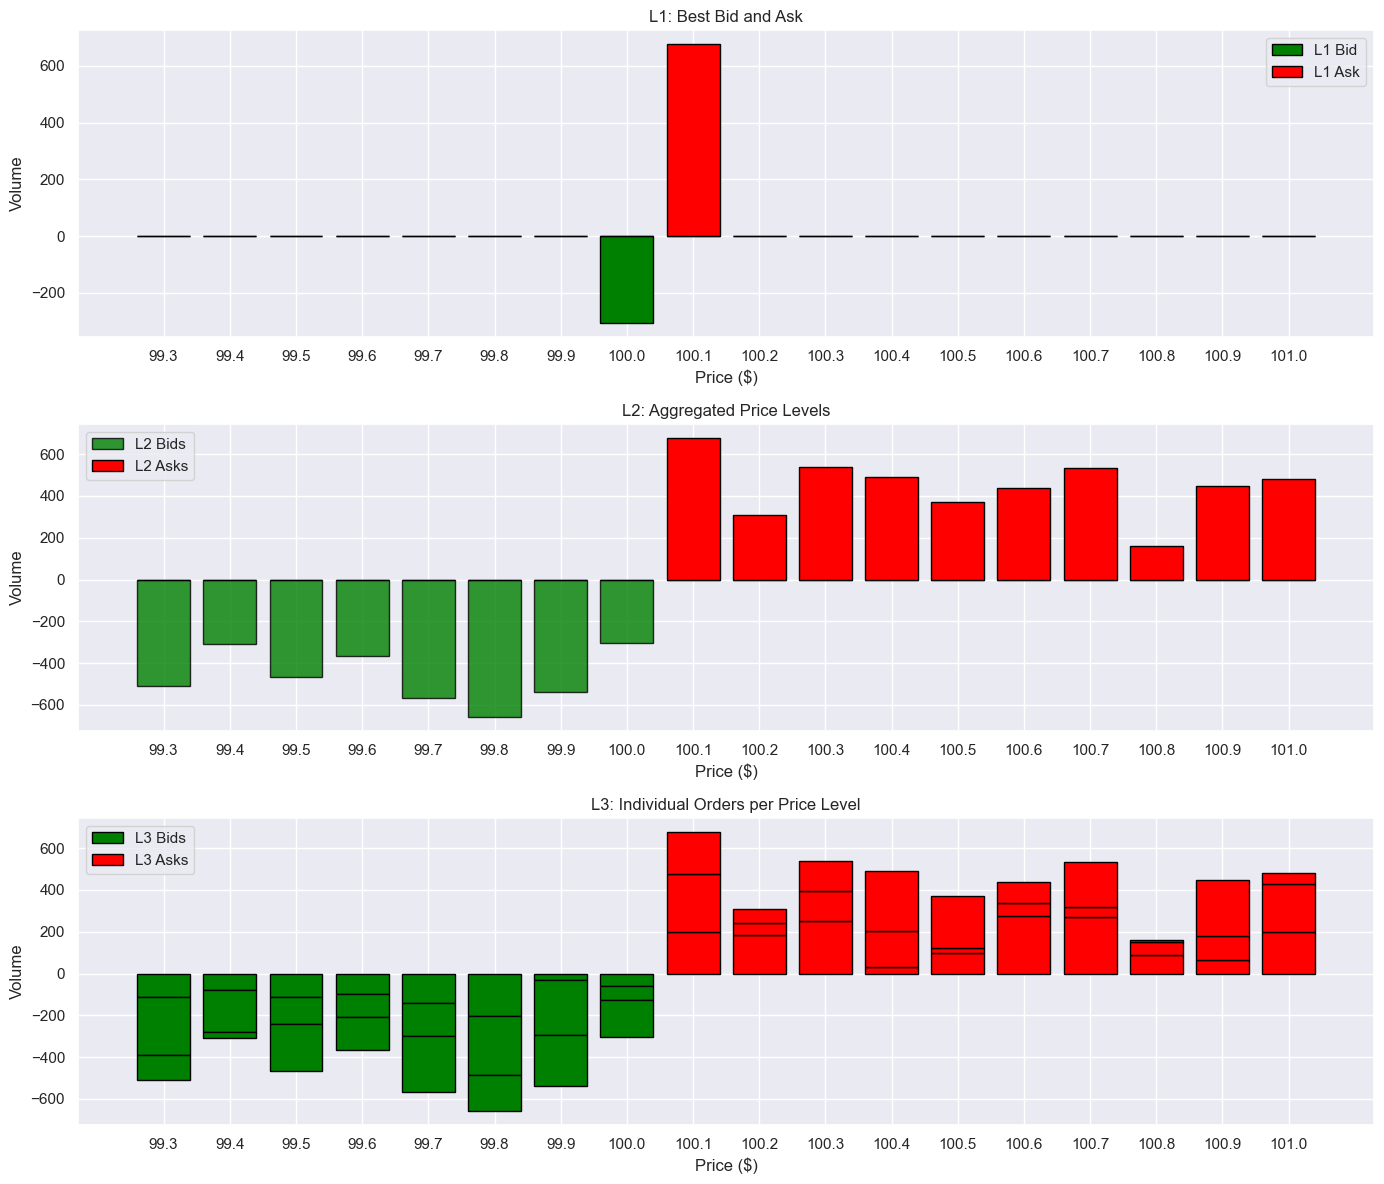

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# --- Generate Full L3 DataFrame Only ---
def generate_l3_data(price_levels):
    # Use the price_levels variable already present in the notebook
    # Generate synthetic L3 data with 5 orders per price level, random sizes

    np.random.seed(42)  # For reproducibility
    mid_price = 100

    prices = price_levels
    sides = ['bid' if p <= mid_price else 'ask' for p in prices]

    order_id = 1
    rows = []
    for price, side in zip(prices, sides):
        for j in range(3):
            size = np.random.randint(10, 300)  # Random size between 50 and 300
            timestamp = pd.Timestamp('2025-01-01') + pd.Timedelta(seconds=order_id + j)
            rows.append({
                'order_id': order_id,
                'price': float(price),
                'size': size,
                'side': side,
                'timestamp': timestamp
            })
            order_id += 1

    return pd.DataFrame(rows)

# --- Derive L1 from L3 ---
def extract_l1(l3_df):
    best_bid = l3_df[l3_df['side'] == 'bid'].sort_values(by='price', ascending=False).iloc[0]
    best_ask = l3_df[l3_df['side'] == 'ask'].sort_values(by='price', ascending=True).iloc[0]
    return {
        'best_bid_price': best_bid['price'],
        'best_bid_size': l3_df[(l3_df['price'] == best_bid['price']) & (l3_df['side'] == 'bid')]['size'].sum(),
        'best_ask_price': best_ask['price'],
        'best_ask_size': l3_df[(l3_df['price'] == best_ask['price']) & (l3_df['side'] == 'ask')]['size'].sum()
    }

# --- Derive L2 from L3 ---
def aggregate_l2_from_l3(l3_df):
    return l3_df.groupby(['price', 'side'])['size'].sum().reset_index()

# --- Main ---
if __name__ == '__main__':
    price_levels = np.arange(99.3, 101, 0.1)  # example: from 98.5 to 101.5

    l3_df = generate_l3_data(price_levels)
    l1 = extract_l1(l3_df)
    l2 = aggregate_l2_from_l3(l3_df)
    # price_levels = sorted(l3_df['price'].unique())

    fig, axs = plt.subplots(3, 1, figsize=(14, 12))

    # --- L1 ---
    bid_sizes_l1 = [l1['best_bid_size'] * -1 if price == l1['best_bid_price'] else 0 for price in price_levels]
    ask_sizes_l1 = [l1['best_ask_size'] if price == l1['best_ask_price'] else 0 for price in price_levels]
    axs[0].bar(price_levels, bid_sizes_l1, width=0.08, color='green', alpha=1, label='L1 Bid', edgecolor='black')
    axs[0].bar(price_levels, ask_sizes_l1, width=0.08, color='red', alpha=1, label='L1 Ask', edgecolor='black')
    axs[0].set_xticks(price_levels)
    axs[0].set_title("L1: Best Bid and Ask")
    axs[0].set_ylabel("Volume")
    axs[0].set_xlabel("Price ($)")
    axs[0].legend()

    # --- L2 ---
    bids_l2 = l2[l2['side'] == 'bid'].set_index('price').reindex(price_levels, fill_value=0)
    asks_l2 = l2[l2['side'] == 'ask'].set_index('price').reindex(price_levels, fill_value=0)
    axs[1].bar(price_levels, bids_l2['size'] * -1, width=0.08, color='green', alpha=0.8, label='L2 Bids', edgecolor='black')
    axs[1].bar(price_levels, asks_l2['size'], width=0.08, color='red', alpha=1, label='L2 Asks', edgecolor='black')
    axs[1].set_title("L2: Aggregated Price Levels")
    axs[1].set_ylabel("Volume")
    axs[1].legend()
    axs[1].set_xlabel("Price ($)")
    axs[1].set_xticks(price_levels)

    # --- L3 ---
    grouped = l3_df.groupby(['price', 'side'])
    bar_width = 0.08
    # bar_offset = {'bid': -bar_width/2, 'ask': bar_width/2}
    colors = {'bid': 'green', 'ask': 'red'}
    for (price, side), group in grouped:
        total_height = 0
        for _, row in group.iterrows():
            axs[2].bar(
                price,
                row['size'] * (-1 if side == 'bid' else 1),
                bottom=total_height if side == 'ask' else -total_height,
                width=bar_width,
                color=colors[side],
                edgecolor='black',
                linewidth=1,
                alpha=1,
                zorder=1
            )
            if side == 'ask':
                total_height += row['size']
            else:
                total_height += row['size']
    axs[2].set_title("L3: Individual Orders per Price Level")
    axs[2].set_xlabel("Price ($)")
    axs[2].set_ylabel("Volume")
    axs[2].set_xticks(price_levels)
    custom_legend = [
        Patch(facecolor='green', edgecolor='black', label='L3 Bids'),
        Patch(facecolor='red', edgecolor='black', label='L3 Asks')
    ]
    axs[2].legend(handles=custom_legend)

    plt.tight_layout()
    plt.show()

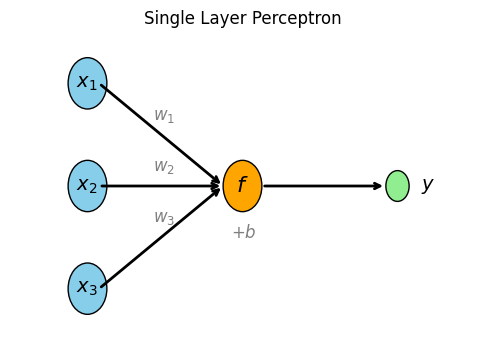

In [9]:
import matplotlib.pyplot as plt

def draw_perceptron():
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.axis('off')

    # Draw input nodes
    input_coords = [(1, 2.5), (1, 1.5), (1, 0.5)]
    for i, (x, y) in enumerate(input_coords):
        circle = plt.Circle((x, y), 0.25, color='skyblue', ec='black', zorder=2)
        ax.add_patch(circle)
        ax.text(x-0.15, y, f'$x_{i+1}$', fontsize=14, va='center')

    # Draw perceptron node
    perceptron_x, perceptron_y = 3, 1.5
    perceptron = plt.Circle((perceptron_x, perceptron_y), 0.25, color='orange', ec='black', zorder=2)
    ax.add_patch(perceptron)
    ax.text(perceptron_x, perceptron_y, '$f$', fontsize=16, ha='center', va='center', color='black')

    # Draw output node
    output_x, output_y = 5, 1.5
    output = plt.Circle((output_x, output_y), 0.15, color='lightgreen', ec='black', zorder=2)
    ax.add_patch(output)
    ax.text(output_x+0.3, output_y, '$y$', fontsize=14, va='center')

    # Draw arrows from inputs to perceptron
    for x, y in input_coords:
        ax.annotate('', xy=(perceptron_x-0.25, perceptron_y), xytext=(x+0.15, y),
                    arrowprops=dict(arrowstyle='->', lw=2))

    # Draw arrow from perceptron to output
    ax.annotate('', xy=(output_x-0.15, output_y), xytext=(perceptron_x+0.25, perceptron_y),
                arrowprops=dict(arrowstyle='->', lw=2))

    # Add weights labels
    for i, (x, y) in enumerate(input_coords):
        ax.text((x+perceptron_x)/2 - 0.15, (y+perceptron_y)/2 + 0.15, f'$w_{i+1}$', fontsize=12, color='gray')

    # Add bias label
    ax.text(perceptron_x - 0.15, perceptron_y-0.5, '$+b$', fontsize=12, color='gray')

    ax.set_xlim(0, 6)
    ax.set_ylim(0, 3)
    ax.set_title("Single Layer Perceptron")
    plt.show()

draw_perceptron()

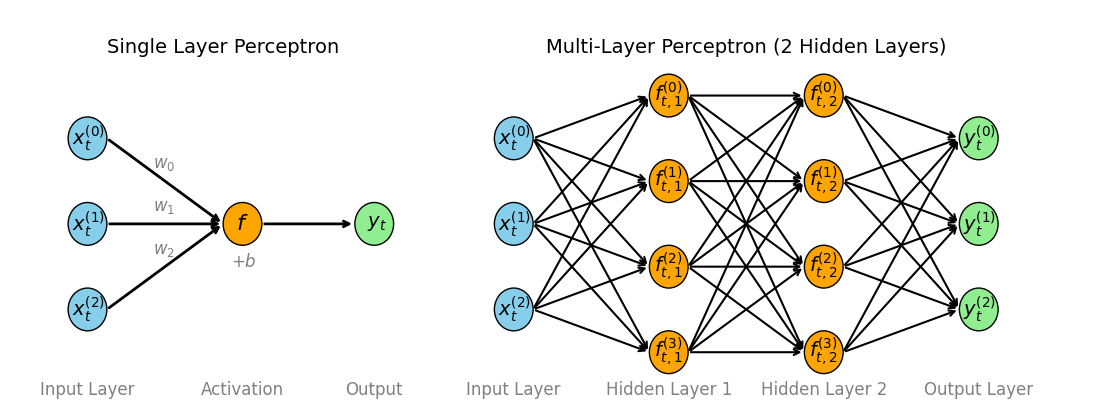

In [10]:
import matplotlib.pyplot as plt

def draw_perceptron_and_mlp_two_hidden():
    fig, ax = plt.subplots(figsize=(14, 5))
    ax.axis('off')

    # --- Single Layer Perceptron (Left Side) ---
    input_coords = [(1, 2.5), (1, 1.5), (1, 0.5)]
    for index, (x, y) in enumerate(input_coords):
        ax.add_patch(plt.Circle((x, y), 0.25, color='skyblue', ec='black'))
        ax.text(x - 0.2, y, f"$x^{{({index})}}_t$", fontsize=14, va='center')
    ax.text(input_coords[0][0], -0.5, "Input Layer", fontsize=12, ha='center', color='gray')

    perceptron_x, perceptron_y = 3, 1.5
    ax.add_patch(plt.Circle((perceptron_x, perceptron_y), 0.25, color='orange', ec='black'))
    ax.text(perceptron_x, perceptron_y, '$f$', fontsize=16, ha='center', va='center', color='black')
    ax.text(perceptron_x, -0.5, "Activation", fontsize=12, ha='center', color='gray')

    output_x, output_y = 4.7, 1.5
    ax.add_patch(plt.Circle((output_x, output_y), 0.25, color='lightgreen', ec='black'))
    ax.text(output_x -0.1, output_y, '$y_t$', fontsize=14, va='center')
    ax.text(output_x, -0.5, "Output", fontsize=12, ha='center', color='gray')

    for x, y in input_coords:
        ax.annotate('', xy=(perceptron_x - 0.25, perceptron_y), xytext=(x + 0.25, y),
                    arrowprops=dict(arrowstyle='->', lw=2))

    ax.annotate('', xy=(output_x - 0.25, output_y), xytext=(perceptron_x + 0.25, perceptron_y),
                arrowprops=dict(arrowstyle='->', lw=2))

    for i, (x, y) in enumerate(input_coords):
        ax.text((x + perceptron_x)/2 - 0.15, (y + perceptron_y)/2 + 0.15, f'$w_{i}$', fontsize=12, color='gray')
    ax.text(perceptron_x - 0.15, perceptron_y - 0.5, '$+b$', fontsize=12, color='gray')
    ax.text(2.75, 3.5, "Single Layer Perceptron", fontsize=14, ha='center')

    # --- Multi-Layer Perceptron (Right Side, with 2 hidden layers) ---
    x_offset = 6.5
    input_layer = [(x_offset + 0, 2.5), (x_offset + 0, 1.5), (x_offset + 0, 0.5)]
    hidden_layer1 = [(x_offset + 2, 3), (x_offset + 2, 2), (x_offset + 2, 1), (x_offset + 2, 0)]
    hidden_layer2 = [(x_offset + 4, 3), (x_offset + 4, 2), (x_offset + 4, 1), (x_offset + 4, 0)]
    output_layer = [(x_offset + 6, 2.5),(x_offset + 6, 1.5), (x_offset + 6, 0.5)]

    for index, (x, y) in enumerate(input_layer):
        ax.add_patch(plt.Circle((x, y), 0.25, color='skyblue', ec='black'))
        ax.text(x - 0.2, y, f"$x^{{({index})}}_t$", fontsize=14, va='center')
    ax.text(input_layer[0][0], -0.5, "Input Layer", fontsize=12, ha='center', color='gray')

    for index, (x, y) in enumerate(hidden_layer1):
        ax.add_patch(plt.Circle((x, y), 0.25, color='orange', ec='black'))
        ax.text(x, y, f"$f^{{({index})}}_{{t,1}}$", fontsize=14, ha='center', va='center', color='black')
    # Label for hidden layer 1
    ax.text(x_offset + 2, -0.5, "Hidden Layer 1", fontsize=12, ha='center', color='gray')

    for index, (x, y) in enumerate(hidden_layer2):
        ax.add_patch(plt.Circle((x, y), 0.25, color='orange', ec='black'))
        ax.text(x, y, f"$f^{{({index})}}_{{t,2}}$", fontsize=14, ha='center', va='center', color='black')
    # Label for hidden layer 2
    ax.text(x_offset + 4, -0.5, "Hidden Layer 2", fontsize=12, ha='center', color='gray')

    for index, (x, y) in enumerate(output_layer):
        ax.add_patch(plt.Circle((x, y), 0.25, color='lightgreen', ec='black'))
        ax.text(x - 0.2, y, f"$y^{{({index})}}_t$", fontsize=14, va='center')
    ax.text(output_layer[0][0], -0.5, "Output Layer", fontsize=12, ha='center', color='gray')

    for xi, yi in input_layer:
        for xh, yh in hidden_layer1:
            ax.annotate('', xy=(xh - 0.25, yh), xytext=(xi + 0.25, yi),
                        arrowprops=dict(arrowstyle='->', lw=1.5))

    for xh1, yh1 in hidden_layer1:
        for xh2, yh2 in hidden_layer2:
            ax.annotate('', xy=(xh2 - 0.25, yh2), xytext=(xh1 + 0.25, yh1),
                        arrowprops=dict(arrowstyle='->', lw=1.5))

    for xh2, yh2 in hidden_layer2:
        for xh, yh in output_layer:
            ax.annotate('', xy=(xh - 0.25, yh), xytext=(xh2 + 0.25, yh2),
                        arrowprops=dict(arrowstyle='->', lw=1.5))

    ax.text(x_offset + 3, 3.5, "Multi-Layer Perceptron (2 Hidden Layers)", fontsize=14, ha='center')

    ax.set_xlim(0, 14)
    ax.set_ylim(-0.5, 4)
    plt.show()

draw_perceptron_and_mlp_two_hidden()


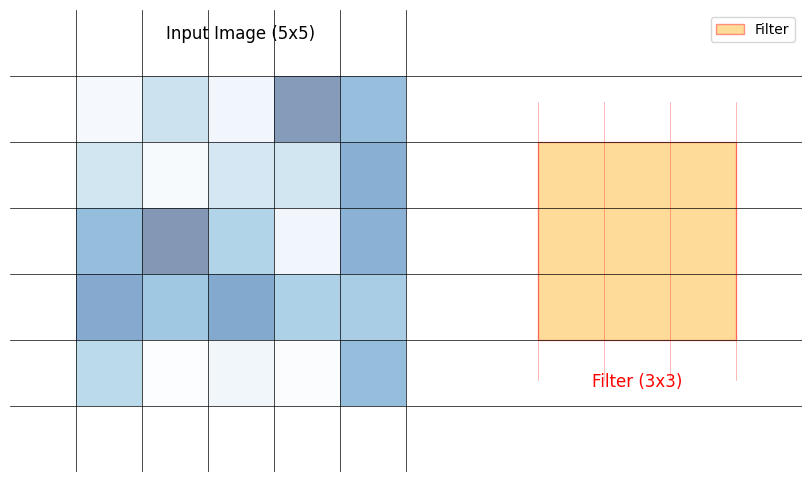

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Define image and filter sizes
image_size = 5  # 5x5 image
filter_size = 3  # 3x3 filter

# Create the input image grid
image = np.random.rand(image_size, image_size)  # Random image for visualization
ax.imshow(image, cmap='Blues', extent=[0, image_size, 0, image_size], alpha=0.5)

# Draw grid lines for the image
for i in range(image_size + 1):
    ax.axhline(i, color='black', linewidth=0.5)
    ax.axvline(i, color='black', linewidth=0.5)

# Add the filter patch next to the image
filter_x = image_size + 2  # Offset to place filter to the right
filter_patch = patches.Rectangle((filter_x, 1), filter_size, filter_size, 
                                edgecolor='red', facecolor='orange', alpha=0.4, label='Filter')
ax.add_patch(filter_patch)

# Draw grid lines for the filter
for i in range(filter_size + 1):
    # Horizontal lines
    ax.axhline(1 + i, xmin=filter_x/image_size, xmax=(filter_x + filter_size)/image_size, 
               color='red', linewidth=0.5, alpha=0.4)
    # Vertical lines
    ax.axvline(filter_x + i, ymin=1/image_size, ymax=(1 + filter_size)/image_size, 
               color='red', linewidth=0.5, alpha=0.4)

# Add labels
ax.text(image_size/2, image_size + 0.5, 'Input Image (5x5)', ha='center', va='bottom', fontsize=12)
ax.text(filter_x + filter_size/2, 0.5, 'Filter (3x3)', ha='center', va='top', fontsize=12, color='red')

# Set plot limits
ax.set_xlim(-1, image_size + filter_size + 3)
ax.set_ylim(-1, image_size + 1)
ax.set_aspect('equal')
ax.axis('off')

# Add legend
ax.legend(loc='upper right')

plt.show()

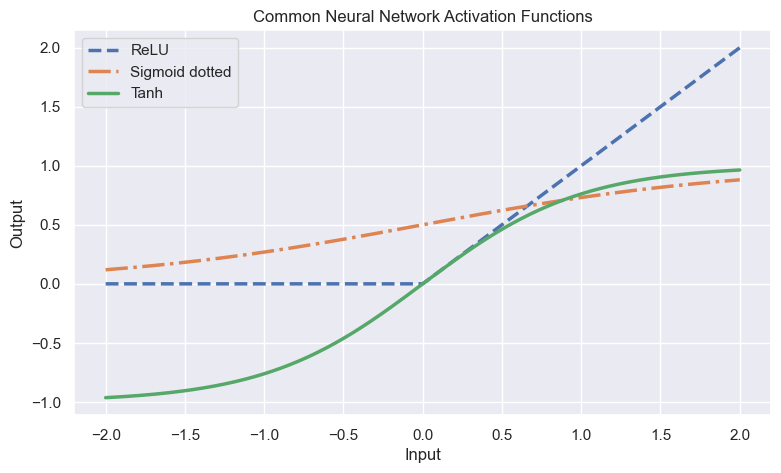

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
x = np.linspace(-2, 2, 500)
relu = np.maximum(0, x)
sigmoid = 1 / (1 + np.exp(-x))
tanh = np.tanh(x)

plt.figure(figsize=(9, 5))
plt.plot(x, relu, label='ReLU', linewidth=2.5, linestyle='--')
# Common matplotlib line styles:
# '-'   : solid line
# '--'  : dashed line
# '-.'  : dash-dot line
# ':'   : dotted line
# '' or ' ' : no line (just markers)

plt.plot(x, sigmoid, label='Sigmoid dotted', linewidth=2.5, linestyle='-.')    # dotted
plt.plot(x, tanh, label='Tanh', linewidth=2.5)
plt.title('Common Neural Network Activation Functions')
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
import numpy as np
from src.core.constants import NUMPY_X_KEY

file = r'C:\Users\benhu\UCL\Term 3\HSBC\deep-lob-project\data\processed\AAPL\orderfixedvol\scaled\AAPL_orderfixedvol_2025-06-03.npz'
with np.load(file) as data:
    # print(list(data.keys()))
    data = data[NUMPY_X_KEY]
    print(data.shape)
print(data)


(99901, 100, 30)
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0.